In [1]:
#first import torch, torchvision and the MNIST dataset loader
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
dataset = MNIST(root='mnist/',download=True)

Extracting mnist/MNIST\raw\train-images-idx3-ubyte.gz to mnist/MNIST\raw


Extracting mnist/MNIST\raw\train-labels-idx1-ubyte.gz to mnist/MNIST\raw



Extracting mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to mnist/MNIST\raw


Extracting mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist/MNIST\raw
Processing...


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [5]:
import os

In [8]:
os.listdir('mnist/MNIST/processed')

['test.pt', 'training.pt']

In [9]:
#so the dataset already has 2 splits into test and train
#by default when MNIST dataset constructor is called it picks only train set, the test set can be imported by specifying train=False
train_dataset = MNIST(root='mnist/')
test_dataset  = MNIST(root='mnist/',train=False)

In [10]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [11]:
#so 60k train and 10k test images
#to see what image looks like we need to plot via matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The digit is 3


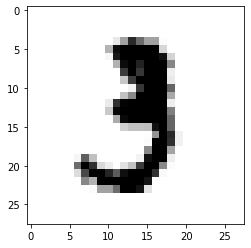

In [19]:
image,label = train_dataset[10]
plt.imshow(image,cmap='Greys')
print(f"The digit is {label}")

In [20]:
#the images are not HD, as they are of size 28*28, the number 3 is not even clear to me
import torchvision.transforms as transforms

In [21]:
#now dataset imported is not in form of tensors
#we can convert manually, or just use transforms.ToTensor in the dataset constructor
train_dataset = MNIST(root='mnist/',train=True,transform=transforms.ToTensor())
test_dataset = MNIST(root='mnist/',train=False,transform=transforms.ToTensor())

In [27]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [28]:
#now we have train and test splits but a validation set is also needed, so I'll split the train set into 2 parts
from torch.utils.data import random_split

In [35]:
train_data, valid_data = random_split(train_dataset,[50000,10000])

In [36]:
#now we have the dataset in form of tensors, next step: create the dataLoader to load data in batches
from torch.utils.data import DataLoader

In [40]:
batch_size = 128
learning_rate = 0.001

input_size = 28*28
num_classes= 10

In [42]:
train_loader = DataLoader(train_data,batch_size,shuffle=True)
valid_loader = DataLoader(valid_data,batch_size) #no shuffle required as only used to measure model performance
test_loader = DataLoader(test_dataset,batch_size)

In [44]:
#now to create model, it is better to define all related functions in a model class
#inherit your model class from torch.nn.Module
import torch.nn as nn
import torch.nn.functional as F

In [62]:
class MnistModel(nn.Module):
    #constructor method
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,num_classes)
        
    def forward(self,X_batch):
        X_batch = X_batch.reshape(-1,784)
        out = self.linear(X_batch)
        return out
    
    def train_step(self,X_batch):
        images,labels = X_batch
        out = self.forward(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def valid_step(self,X_batch):
        images,labels = X_batch
        out = self.forward(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'valid_loss':loss.detach(), 'valid_accuracy':acc.detach()}

In [63]:
model = MnistModel()

In [64]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [67]:
def evaluate(model,valid_loader):
    outputs = [model.valid_step(batch) for batch in valid_loader]
    batch_losses = [x['valid_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() 
    batch_accs = [x['valid_accuracy'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    print(f"'valid_loss': {epoch_loss.item()}, 'valid_accuracy': {epoch_acc.item()}")

In [68]:
evaluate(model,valid_loader)

'valid_loss': 2.3306705951690674, 'valid_accuracy': 0.07565268874168396


In [70]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0145,  0.0247, -0.0111,  ...,  0.0129, -0.0287, -0.0001],
         [ 0.0219, -0.0177,  0.0104,  ...,  0.0013, -0.0218, -0.0232],
         [ 0.0202, -0.0147, -0.0078,  ..., -0.0213, -0.0089,  0.0257],
         ...,
         [ 0.0310,  0.0332,  0.0116,  ...,  0.0299, -0.0062,  0.0087],
         [ 0.0020,  0.0101, -0.0265,  ..., -0.0284,  0.0088,  0.0258],
         [-0.0149, -0.0281,  0.0085,  ...,  0.0348, -0.0066,  0.0231]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0261,  0.0011, -0.0185,  0.0273, -0.0208,  0.0055, -0.0286,  0.0100,
         -0.0008, -0.0044], requires_grad=True)]

In [71]:
def train(model,train_loader,valid_loader,num_epochs=10,lr=0.001,optim_func=torch.optim.SGD):
    optim = optim_func(model.parameters(),lr)
    for epoch in range(num_epochs):
        for batch in train_loader:
            loss = model.train_step(batch)
            loss.backward()
            optim.step()
            optim.zero_grad()
        res = evaluate(model,valid_loader)

In [72]:
train(model,train_loader,valid_loader)

'valid_loss': 1.9616447687149048, 'valid_accuracy': 0.584750771522522
'valid_loss': 1.6902490854263306, 'valid_accuracy': 0.7204311490058899
'valid_loss': 1.487326979637146, 'valid_accuracy': 0.7632516026496887
'valid_loss': 1.3340649604797363, 'valid_accuracy': 0.785897970199585
'valid_loss': 1.2161204814910889, 'valid_accuracy': 0.8014240264892578
'valid_loss': 1.1235768795013428, 'valid_accuracy': 0.8137856125831604
'valid_loss': 1.0494580268859863, 'valid_accuracy': 0.8180379867553711
'valid_loss': 0.9887734055519104, 'valid_accuracy': 0.8221914768218994
'valid_loss': 0.9383103847503662, 'valid_accuracy': 0.8280261158943176
'valid_loss': 0.8957948088645935, 'valid_accuracy': 0.832179605960846


In [73]:
evaluate(model,test_loader)

'valid_loss': 0.8676035404205322, 'valid_accuracy': 0.8404865264892578


In [74]:
#so model trained successfully
#to test on 1 single image
image,label =  test_dataset[7777]

5


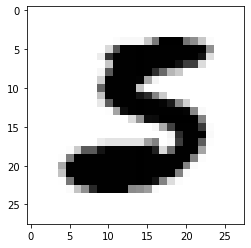

In [77]:
plt.imshow(image[0],cmap='Greys')
print(label)

In [81]:
image = image.unsqueeze(0)
pred_prob = model(image)

In [82]:
pred_prob

tensor([[ 1.3729, -1.1022,  0.7118,  1.4188, -2.9178,  1.6937,  1.2008, -1.5527,
          0.9985, -2.1058]], grad_fn=<AddmmBackward>)

In [83]:
torch.max(pred_prob,dim=1)

torch.return_types.max(
values=tensor([1.6937], grad_fn=<MaxBackward0>),
indices=tensor([5]))

In [84]:
#so predicted label is 5 and the original is also 5, therefore model training successful